In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import warnings

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import FeatureUnion
from sklearn.metrics import roc_auc_score, log_loss, roc_curve
from sklearn.metrics import precision_recall_curve, confusion_matrix

In [3]:
warnings.filterwarnings("ignore")

### Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [4]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [5]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [6]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [7]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [8]:
classifier_1 = Pipeline([
    ('features',feats),
    ('classifier', DecisionTreeRegressor(max_depth = 5)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_1, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_1.fit(X_train, y_train)
y_score = classifier_1.predict(X_test)

CV score is 0.7913490589209934+-0.007430600334447358


Посчитаем precision/recall/f_score

In [9]:
def calculate_print_metrics(b, y_test, y_score):
    b=1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
    return thresholds[ix], fscore[ix], precision[ix], recall[ix]

In [10]:
def print_roc_auc(y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")
    
    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

Best Threshold=0.378747, F-Score=0.735, Precision=0.668, Recall=0.818


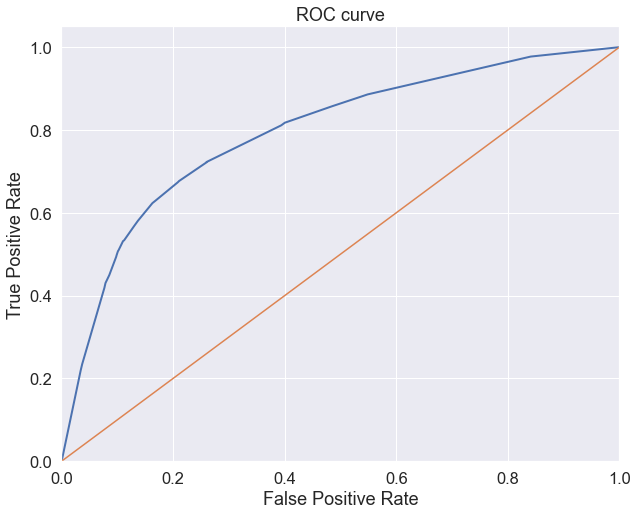

In [11]:
thresholds_1, fscore_1, precision_1, recall_1 = calculate_print_metrics(1, y_test, y_score)
print_roc_auc(y_test, y_score)
cnf_matrix_1 = confusion_matrix(y_test, y_score>thresholds_1)

In [12]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [13]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [14]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [15]:
classifier_2 = Pipeline([
    ('features',feats),
    ('classifier', TweedieRegressor()),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_2, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_2.fit(X_train, y_train)
y_score = classifier_2.predict(X_test)

CV score is 0.6966933270707255+-0.010500971219062327


Best Threshold=0.417278, F-Score=0.690, Precision=0.551, Recall=0.920


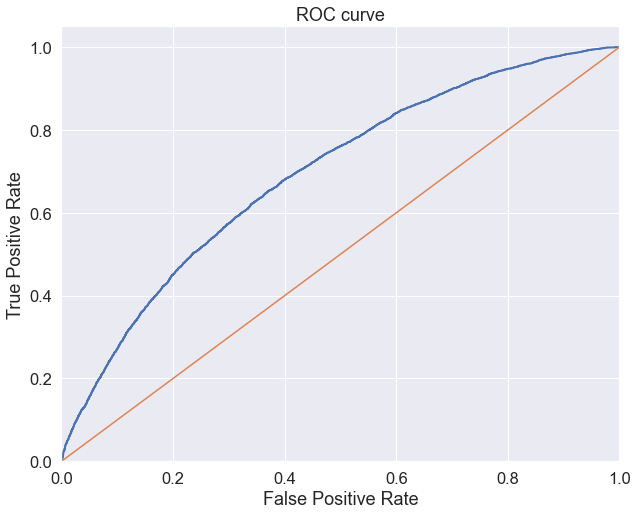

In [16]:
thresholds_2, fscore_2, precision_2, recall_2 = calculate_print_metrics(1, y_test, y_score)
print_roc_auc(y_test, y_score)
cnf_matrix_2 = confusion_matrix(y_test, y_score>thresholds_2)

In [17]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [18]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [19]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [20]:
classifier_2 = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression()),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_2, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_2.fit(X_train, y_train)
y_score = classifier_2.predict(X_test)

CV score is 0.7867401104915408+-0.00852135511666111


Best Threshold=1.000000, F-Score=0.706, Precision=0.745, Recall=0.670


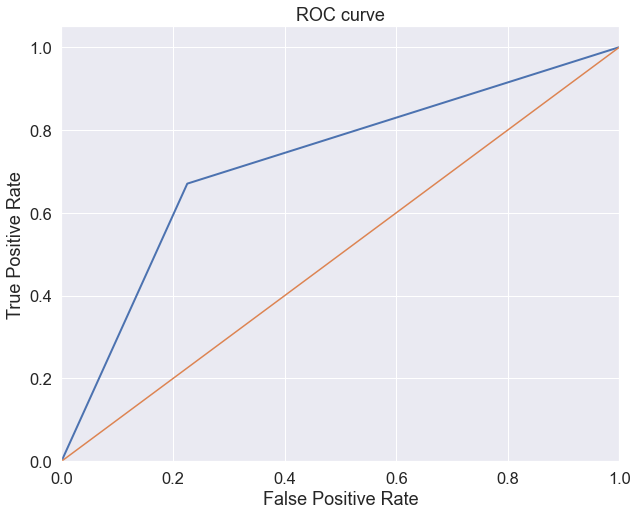

In [21]:
thresholds_3, fscore_3, precision_3, recall_3 = calculate_print_metrics(1, y_test, y_score)
print_roc_auc(y_test, y_score)
cnf_matrix_3 = confusion_matrix(y_test, y_score>0.5)

In [22]:
TN_1 = cnf_matrix_1[0][0]
FN_1 = cnf_matrix_1[1][0]
TP_1 = cnf_matrix_1[1][1]
FP_1 = cnf_matrix_1[0][1]

TPR_1 = TP_1/(TP_1+FN_1)
FPR_1 = FP_1/(FP_1+TN_1)
TNR_1 = TN_1/(FP_1+TN_1)
TPR_1, FPR_1, TNR_1

(0.8111751152073733, 0.39387755102040817, 0.6061224489795919)

In [23]:
TN_2 = cnf_matrix_2[0][0]
FN_2 = cnf_matrix_2[1][0]
TP_2 = cnf_matrix_2[1][1]
FP_2 = cnf_matrix_2[0][1]

TPR_2 = TP_2/(TP_2+FN_2)
FPR_2 = FP_2/(FP_2+TN_2)
TNR_2 = TN_2/(FP_2+TN_2)
TPR_2, FPR_2, TNR_2

(0.9200460829493088, 0.7368480725623583, 0.2631519274376417)

In [24]:
TN_3 = cnf_matrix_3[0][0]
FN_3 = cnf_matrix_3[1][0]
TP_3 = cnf_matrix_3[1][1]
FP_3 = cnf_matrix_3[0][1]

TPR_3 = TP_3/(TP_3+FN_3)
FPR_3 = FP_3/(FP_3+TN_3)
TNR_3 = TN_3/(FP_3+TN_3)
TPR_3, FPR_3, TNR_3

(0.6703917050691244, 0.22551020408163266, 0.7744897959183673)

In [25]:
print("DecisionTreeRegressor: ", "fscore = ", fscore_1, "precision = ", precision_1, "recall = ", recall_1)
print("TweedieRegressor: ", "fscore = ", fscore_2, "precision = ", precision_2, "recall = ", recall_2)
print("LogisticRegression: ", "fscore = ", fscore_3, "precision = ", precision_3, "recall = ", recall_3)

DecisionTreeRegressor:  fscore =  0.7350701817993474 precision =  0.6677331325868072 recall =  0.8175115207373271
TweedieRegressor:  fscore =  0.6895450228783562 precision =  0.5513599337291177 recall =  0.9201612903225806
LogisticRegression:  fscore =  0.7058466763706938 precision =  0.7452612704918032 recall =  0.6703917050691244


В данном случае, лучше всех отработала вторая модель, так как нам важно по максимуму диагностировать заболевание, если оно есть. Так как recall показывает долю всех больных нашёл алгоритм, нам нужна модель, давшая максимальный recall. А это вторая модель.

(опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого)

Больше подходит метрика roc_auc_curve, так как precision_recall_curve не сможет показать, насколько хорош алгоритм из-за того, что будет оценивать его только с точки зрения правильно угаданных объектов одного класса.